# Continuing with AlexNet on CIFAR-10 dataset

This notebook is a continuation of the MNIST example, found here:

https://github.com/zsolt-balla/batch_norm_lite/blob/master/MNIST_batchnorm.ipynb



# The Setup

Importing packages, defining CNN class (with optional Batch Normalisation) and the training function

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

seed=42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)



# a cosmetic function for compulsive reasons, skip
def pad(num, l):
  s = str(num)[:l]
  return(s + ' ' * (l - len(s)))

In [3]:
def load_and_transform(batchsize=128):
    global train_loader, test_loader
    transform = transforms.Compose(
                [transforms.Resize((224,224)) ,
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                ])
            
    # download and transform train dataset
    train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('../cifar_data', download=True, train=True, transform=transform), 
    batch_size=batchsize, shuffle=True,num_workers=4)

    # download and transform test dataset
    test_loader = torch.utils.data.DataLoader(datasets.CIFAR10('../cifar_data', download=True, train=False, transform=transform),
    batch_size=batchsize, shuffle=True,num_workers=4)

In [4]:
class CNNClassifier(nn.Module):  
    #ALexNet
    BNFunction = nn.BatchNorm2d
    normlayers = []
    def __init__(self, num_classes=10, normlayers=[True, True, True, True, True]):
            BNFunction = nn.BatchNorm2d
            super(CNNClassifier, self).__init__()
            
            # creating argument list for nn.Sequential (this enables easy parametric argument passing)
            #                | layers:
            layers = []
            layers.append(    nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2))
            if(normlayers[0]):
              layers.append(  BNFunction(64))
            layers.extend([   nn.ReLU(inplace=True),
                              nn.MaxPool2d(kernel_size=2, stride=2),
                              nn.Conv2d(64, 192, kernel_size=5, padding=2)])
            if(normlayers[1]):
              layers.append(  BNFunction(192))
            layers.extend([   nn.ReLU(inplace=True),
                              nn.MaxPool2d(kernel_size=2, stride=2),
                              nn.Conv2d(192, 384, kernel_size=3, padding=1)])
            if(normlayers[2]):
              layers.append(  BNFunction(384))
            layers.extend([   nn.ReLU(inplace=True),
                              nn.Conv2d(384, 256, kernel_size=3, padding=1)])
            if(normlayers[3]):
              layers.append(  BNFunction(256))
            layers.extend([   nn.ReLU(inplace=True),
                              nn.Conv2d(256, 256, kernel_size=3, padding=1)])
            if(normlayers[4]):
              layers.append(  BNFunction(256))
            layers.extend([   nn.ReLU(inplace=True),
                              nn.MaxPool2d(kernel_size=2, stride=2)])

            
            self.features = nn.Sequential(*layers)
            self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
            self.classifier = nn.Sequential(
                    nn.Dropout(),
                    nn.Linear(256 * 6 * 6, 4096),
                    nn.ReLU(inplace=True),
                    nn.Dropout(),
                    nn.Linear(4096, 4096),
                    nn.ReLU(inplace=True),
                    nn.Linear(4096, num_classes),
                )

    def forward(self, x):
                x = self.features(x)
                x = self.avgpool(x)
                x = x.view(x.size(0), -1)
                x = self.classifier(x)
                return F.log_softmax(x,dim=-1)


In [5]:
def train(epoch):
  
  for batch_id, (data, label) in enumerate(train_loader):
      clf.train()
      data=data.cuda()
      label=label.cuda()
      opt.zero_grad()
      preds = clf(data)
      loss = F.nll_loss(preds, label)
      loss.backward()
      train_loss_history[-1].append(loss.item())
      opt.step()
      predind = preds.data.max(1)[1] 
      acc = predind.eq(label.data).cpu().float().mean() 
      train_acc_history[-1].append(acc)
      
      if batch_id % 100 == 0:
          #print("Train Loss: " + str(loss.item()) + " Acc: " + str(acc.item()))
          metrics = "Train Loss: " + pad(loss.item(), 7) + " Acc: " + pad(acc.item(), 4)

          #run independent test
          clf.eval() # set model in inference mode (need this because of dropout)
          test_loss = 0
          correct = 0
      
          for data, target in test_loader: 
              data=data.cuda()
              target=target.cuda()  
              with torch.no_grad():    
                  output = clf(data)
                  test_loss += F.nll_loss(output, target).item()
                  pred = output.data.max(1)[1] 
                  correct += pred.eq(target.data).cpu().sum()

          test_loss = test_loss
          test_loss /= len(test_loader) # loss function already averages over batch size
          accuracy =  correct.item() / len(test_loader.dataset)
          #print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
          #    test_loss, correct, len(test_loader.dataset),
          #    accuracy))
          test_acc_history[-1].append(accuracy)
          test_loss_history[-1].append(test_loss)
          #print("Test Loss: "+str(test_loss)+" Acc: "+str(accuracy))
          metrics += "  |  Test Loss: " + pad(test_loss, 7) + " Acc: " + pad(accuracy, 4)
          print(metrics)

In [6]:
def run_training(norm_layers=[True, True, True, True, True], epochs=6, batch_size=128): # also had: repeat
    #for repeat in range(0, repeat):
        global clf, opt
        clf = CNNClassifier(10, norm_layers).cuda()

        #for p in clf.parameters():
        #    print(p.shape)
        opt = optim.SGD(clf.parameters(), lr=0.01, momentum=0.5)
        #opt = optim.Adam(clf.parameters(), lr=0.01)
        
        train_loss_history.append([])
        train_acc_history.append([])
        test_loss_history.append([])
        test_acc_history.append([])
        for epoch in range(0, epochs):
            print("Epoch %d" % epoch)
            train(epoch)
        
    #torch.save(clf.state_dict(), "MyNetMnist")
    #np.save(BNType+"_train_loss.npy",np.array(train_loss_history))
    #np.save(BNType+"_train_acc.npy",np.array(train_acc_history))
    #np.save(BNType+"_test_loss.npy",np.array(test_loss_history))
    #np.save(BNType+"_test_acc.npy",np.array(test_acc_history))

# Experiment
Defining the experiment function as well as some BN settings.

In [7]:
selection = [[False, False, False, False, False],
             [False, True, False, True, False],
             [True, True, True, True, True]]

In [8]:
#print("Test Filtered")
#RunTest("Filtered",25,10,128)
#print("Test Builtin")
#RunTest("Builtin",25,10,128)

# train the network with a specific set of normalisation settings, for N epochs each.
def experiment(epochs, norm_settings):
  load_and_transform()
  for list in norm_settings:
    print('\nTraining with ' + str(list))
    run_training(list, epochs)

In [9]:
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

experiment(6, selection)

Extracting ../cifar_data/cifar-10-python.tar.gz to ../cifar_data
Files already downloaded and verified

Training with [False, False, False, False, False]
Epoch 0
Train Loss: 2.30235 Acc: 0.10  |  Test Loss: 2.30259 Acc: 0.1 
Train Loss: 2.30348 Acc: 0.12  |  Test Loss: 2.30250 Acc: 0.11
Train Loss: 2.30197 Acc: 0.07  |  Test Loss: 2.30241 Acc: 0.1 
Train Loss: 2.30281 Acc: 0.08  |  Test Loss: 2.30225 Acc: 0.1 
Epoch 1
Train Loss: 2.30219 Acc: 0.07  |  Test Loss: 2.30208 Acc: 0.1 
Train Loss: 2.30190 Acc: 0.14  |  Test Loss: 2.30186 Acc: 0.10
Train Loss: 2.30172 Acc: 0.08  |  Test Loss: 2.30152 Acc: 0.15
Train Loss: 2.30091 Acc: 0.17  |  Test Loss: 2.30098 Acc: 0.16
Epoch 2
Train Loss: 2.30063 Acc: 0.07  |  Test Loss: 2.30009 Acc: 0.13
Train Loss: 2.29881 Acc: 0.11  |  Test Loss: 2.29829 Acc: 0.17
Train Loss: 2.29506 Acc: 0.23  |  Test Loss: 2.29366 Acc: 0.20
Train Loss: 2.28094 Acc: 0.11  |  Test Loss: 2.26722 Acc: 0.17
Epoch 3
Train Loss: 2.11034 Acc: 0.20  |  Test Loss: 2.11284 Acc: 

# Impressions

In [10]:
print(test_acc_history)

[[0.1, 0.1121, 0.1, 0.1, 0.1, 0.1089, 0.1543, 0.1671, 0.1389, 0.1748, 0.2076, 0.1721, 0.2241, 0.2647, 0.2905, 0.3203, 0.3358, 0.3405, 0.3648, 0.3832, 0.3948, 0.3788, 0.4163, 0.4223], [0.1, 0.3501, 0.4035, 0.4742, 0.4873, 0.532, 0.5166, 0.5376, 0.5846, 0.5789, 0.6245, 0.6546, 0.6647, 0.6296, 0.6816, 0.7071, 0.6989, 0.7126, 0.7275, 0.7278, 0.7179, 0.7406, 0.7139, 0.74], [0.1, 0.3912, 0.479, 0.554, 0.5664, 0.5885, 0.5959, 0.6452, 0.6838, 0.6469, 0.6845, 0.7107, 0.6732, 0.7344, 0.7305, 0.7024, 0.7175, 0.7235, 0.7474, 0.7417, 0.6914, 0.7552, 0.7373, 0.7483]]


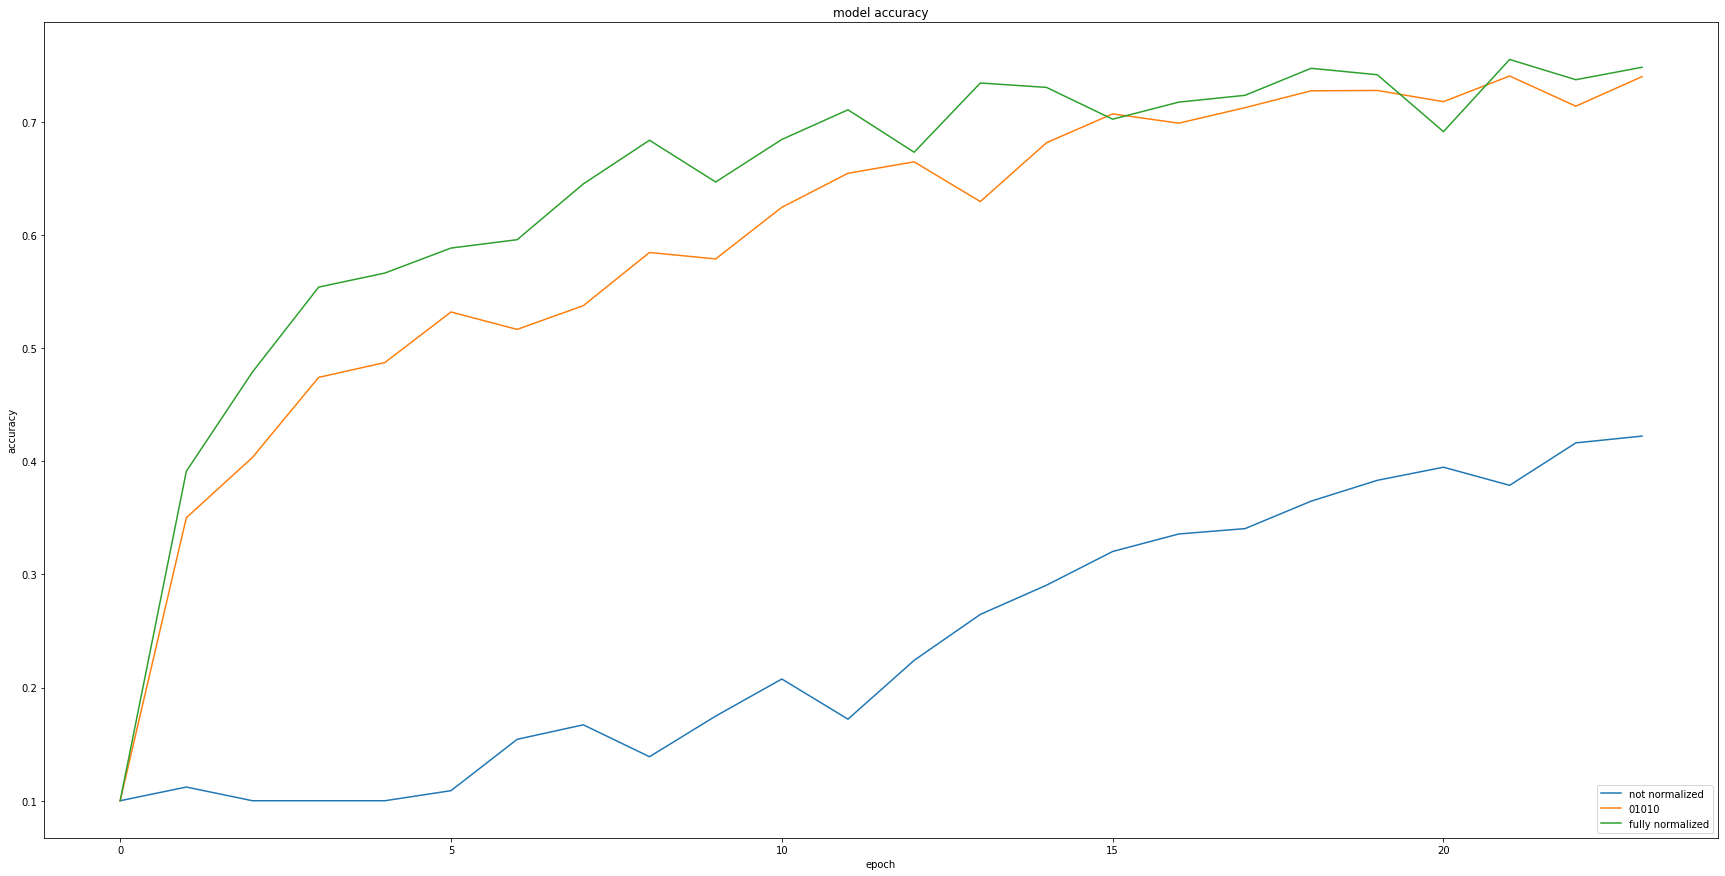

In [11]:
plt.rcParams['figure.figsize'] = (30,15)
for a in test_acc_history:
  plt.plot(range(len(a)), a)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['not normalized', '01010', 'fully normalized'], loc='lower right')
plt.show()